In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_curve
import re
import os
import shutil

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:05<00:00, 70.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [ ]:
mask_data=r"/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1"
folders=os.listdir(mask_data)
annotation_dir=os.path.join(mask_data,folders[1])
image_dir=os.path.join(mask_data,folders[0])
print(len(os.listdir(image_dir)))
print(len(os.listdir(annotation_dir)))

853
853


In [ ]:
os.listdir(annotation_dir)[:5]

['maksssksksss604.xml',
 'maksssksksss453.xml',
 'maksssksksss452.xml',
 'maksssksksss658.xml',
 'maksssksksss150.xml']

In [ ]:

import xml.etree.ElementTree as ET

def extract_category_from_xml(xml_file_path):
  """Extracts the category from an XML file."""
  try:
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    for obj in root.findall('object'):
      category = obj.find('name').text
      return category
  except Exception as e:
    print(f"Error processing XML file {xml_file_path}: {e}")
    return None

categories = []
for xml_filename in os.listdir(annotation_dir):
  if xml_filename.endswith(".xml"):
    xml_file_path = os.path.join(annotation_dir, xml_filename)
    category = extract_category_from_xml(xml_file_path)
    if category:
      categories.append(category)

categories[:10]

['with_mask',
 'without_mask',
 'with_mask',
 'mask_weared_incorrect',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask']

In [ ]:
image_files=os.listdir(image_dir)
image_files[:5]

['maksssksksss141.png',
 'maksssksksss309.png',
 'maksssksksss124.png',
 'maksssksksss803.png',
 'maksssksksss582.png']

In [ ]:
# Sample list of categories
category_names =list(set(categories))
category_names

['mask_weared_incorrect', 'without_mask', 'with_mask']

In [ ]:
os.makedirs("mask_data",exist_ok=True)
parent_folder="mask_data"
for category in category_names:
    category=os.path.join(parent_folder,category)
    os.makedirs(category, exist_ok=True)

In [ ]:

for image, category in zip(image_files, categories):
    folder_name = category.replace(' ', '_')  # Replace spaces with underscores
    source=os.path.join(image_dir,image)
    destination=os.path.join(parent_folder,folder_name)
    shutil.move(source,destination)

In [ ]:
with_mask_data=os.listdir(os.path.join(parent_folder,"with_mask"))
without_mask_data=os.listdir(os.path.join(parent_folder,"without_mask"))
incorrect_mask_data=os.listdir(os.path.join(parent_folder,"mask_weared_incorrect"))
print(f"with mask folder has {len(with_mask_data)} files")
print(f"without mask folder has {len(without_mask_data)} files")
print(f"incorrect mask folder has {len(incorrect_mask_data)} files")


with mask folder has 698 files
without mask folder has 119 files
incorrect mask folder has 36 files


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
os.mkdir("split_mask_data")
splitfolders.ratio(parent_folder,output="split_mask_data",seed=42,ratio=(0.8,0.2))

Copying files: 853 files [00:00, 985.87 files/s]


In [ ]:
import torch
from torch import nn
torch.__version__

'2.5.0+cu121'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torchvision
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def create_ViT_model(num_class:int,
                     seeds:int=42):
  #GEt pretrained weights for ViT-Base
  pretrained_vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT  # Default = best avaialable

  # Getting automatic transforms from pretrained ViT weights
  vit_transforms=pretrained_vit_weights.transforms()

  # Setup a ViT model instance with pretrained weights
  pretrained_vit=torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

  # Freeze the base parameters
  for parameter in pretrained_vit.parameters():
    parameter.requires_grad=False

  # Updating the classifier head
  pretrained_vit.heads=nn.Linear(in_features=768,
                                out_features=num_class).to(device)
  return pretrained_vit,vit_transforms

In [ ]:
import torch
from pathlib import Path
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int):
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )




  return train_dataloader, test_dataloader, class_names

In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary
from torchvision.models import resnet50, ResNet50_Weights
num_classes=3
# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
resnet50_transformers = weights.transforms()

resnet50_model= resnet50(weights=weights)



summary(model=resnet50_model,
        input_size=[1,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d: 1-1                            [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU: 1-3                              [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential: 1-5                        [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    └─Bottleneck: 2-1                   [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    │    └─BatchN

In [ ]:
train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir="split_mask_data/train",
                                                              test_dir="split_mask_data/val",
                                                                transform=resnet50_transformers,
                                                                batch_size=32,
                                                                num_workers=os.cpu_count())

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
               # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
              # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
          # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [ ]:
loss_fn= nn.CrossEntropyLoss()

optimizer= torch.optim.SGD(params=resnet50_model.parameters(),lr=1e-3)


resnet50_results=train(model=resnet50_model,
                      train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.9908 | train_acc: 0.0000 | test_loss: 6.7619 | test_acc: 0.0000
Epoch: 2 | train_loss: 6.5018 | train_acc: 0.0000 | test_loss: 6.2663 | test_acc: 0.0104
Epoch: 3 | train_loss: 5.9432 | train_acc: 0.0185 | test_loss: 5.7247 | test_acc: 0.0417
Epoch: 4 | train_loss: 5.2193 | train_acc: 0.1102 | test_loss: 4.9997 | test_acc: 0.1406
Epoch: 5 | train_loss: 4.2486 | train_acc: 0.3617 | test_loss: 3.9968 | test_acc: 0.4271
Epoch: 6 | train_loss: 3.3087 | train_acc: 0.6001 | test_loss: 3.2631 | test_acc: 0.6094
Epoch: 7 | train_loss: 2.5976 | train_acc: 0.7535 | test_loss: 2.8677 | test_acc: 0.6719
Epoch: 8 | train_loss: 2.1175 | train_acc: 0.7884 | test_loss: 2.5933 | test_acc: 0.7083
Epoch: 9 | train_loss: 1.8750 | train_acc: 0.8024 | test_loss: 2.4765 | test_acc: 0.7135
Epoch: 10 | train_loss: 1.7002 | train_acc: 0.8037 | test_loss: 2.3034 | test_acc: 0.7188
Epoch: 11 | train_loss: 1.4931 | train_acc: 0.8224 | test_loss: 2.2129 | test_acc: 0.7188
Epoch: 12 | train_l

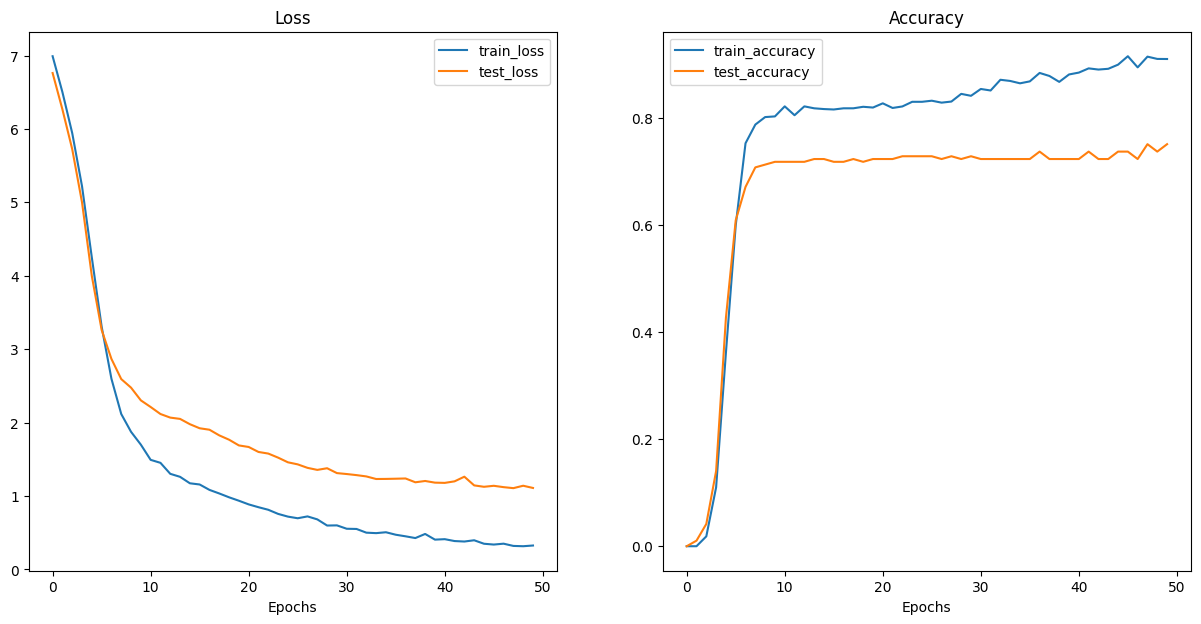

In [ ]:
plot_loss_curves(resnet50_results)

In [ ]:
torch.save(resnet50_model.state_dict(), 'mask_detection_resnet60_50epochs_model.pth')